<a href="https://colab.research.google.com/github/gabrielfea/CMAPSSData/blob/main/Estudo_base_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
207/207 [==============================] - 53s 218ms/step - loss: 5461.6650 - val_loss: 2683.5425
Epoch 2/100
207/207 [==============================] - 44s 210ms/step - loss: 3681.1494 - val_loss: 2515.4460
Epoch 3/100
207/207 [==============================] - 57s 276ms/step - loss: 2543.8979 - val_loss: 1297.4204
Epoch 4/100
207/207 [==============================] - 44s 214ms/step - loss: 1403.7797 - val_loss: 737.9951
Epoch 5/100
207/207 [==============================] - 43s 210ms/step - loss: 910.7030 - val_loss: 613.4459
Epoch 6/100
207/207 [==============================] - 44s 211ms/step - loss: 558.3770 - val_loss: 740.5025
Epoch 7/100
207/207 [==============================] - 43s 208ms/step - loss: 290.1952 - val_loss: 785.9259
Epoch 8/100
207/207 [==============================] - 40s 194ms/step - loss: 198.7806 - val_loss: 764.2586
Epoch 9/100
207/207 [==============================] - 41s 199ms/step - loss: 122.0922 - val_loss: 824.3859
Epoch 10/100
207/207 

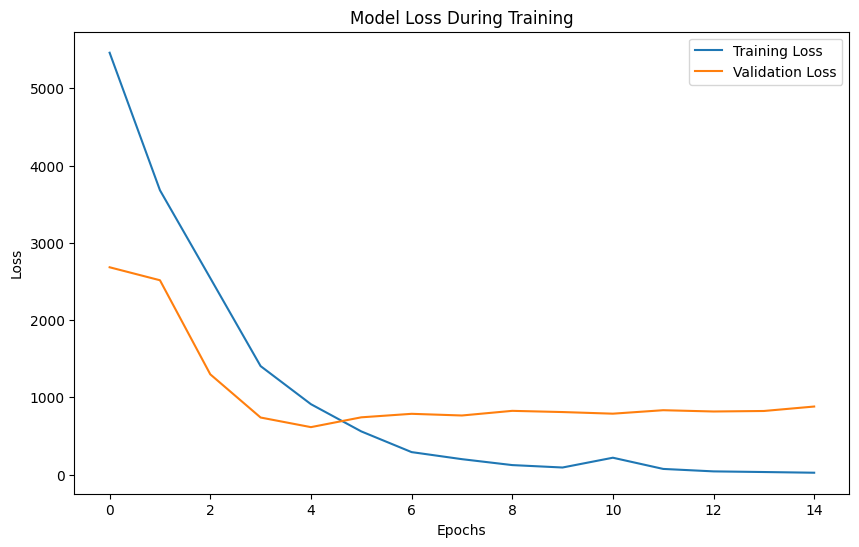

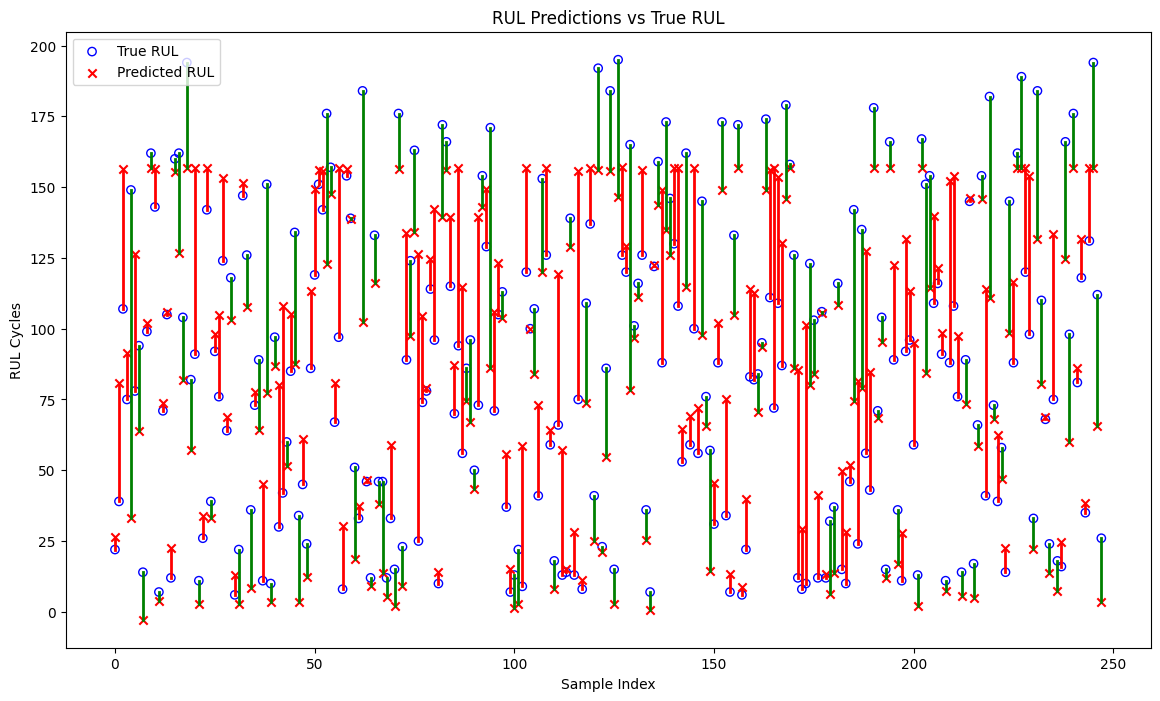

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Layer, MultiHeadAttention, Dropout, LayerNormalization, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tabulate import tabulate
import random

# Função para carregar os dados
def load_data(file_path):
    data = pd.read_csv(file_path, sep=' ', header=None)
    data.dropna(axis=1, how='all', inplace=True)
    return data.values

# Função para preparar os dados de treinamento
def prepare_train_data(data, sequence_length):
    X, y = [], []
    for unit in np.unique(data[:, 0]):
        unit_data = data[data[:, 0] == unit]
        for i in range(len(unit_data) - sequence_length + 1):
            X.append(unit_data[i:i+sequence_length, 2:])
            y.append(len(unit_data) - i - sequence_length)
    return np.array(X), np.array(y)

# Função para preparar os dados de teste
def prepare_test_data(data, sequence_length):
    X = []
    for unit in np.unique(data[:, 0]):
        unit_data = data[data[:, 0] == unit]
        if len(unit_data) >= sequence_length:
            X.append(unit_data[-sequence_length:, 2:])
        else:
            pad_size = sequence_length - len(unit_data)
            padded_data = np.pad(unit_data[:, 2:], ((pad_size, 0), (0, 0)), 'constant')
            X.append(padded_data)
    return np.array(X)

# Transformer Encoder Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Função para construir o modelo
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM
    x = LSTM(100, return_sequences=True)(x)
    x = LSTM(100, return_sequences=False)(x)

    # Transformer
    transformer_block = TransformerBlock(embed_dim=100, num_heads=2, ff_dim=64)
    x = transformer_block(tf.expand_dims(x, axis=1))

    # Flatten and Dense
    x = Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Função para calcular as métricas
def evaluate_model(y_true, y_pred):
    metrics = {
        'Metric': ['R²', 'MAPE', 'MAE', 'MSE', 'RMSE'],
        'Value': [
            r2_score(y_true, y_pred),
            mean_absolute_percentage_error(y_true, y_pred),
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred))
        ]
    }

    df_metrics = pd.DataFrame(metrics)
    print(tabulate(df_metrics, headers='keys', tablefmt='pretty'))

# Função para plotar o histórico de treinamento
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Função para plotar as previsões de RUL como scatter plot com linhas ajustadas
def plot_rul_predictions(y_true, y_pred):
    plt.figure(figsize=(14, 8))  # Aumentar a largura do gráfico
    indices = np.arange(len(y_true))

    plt.scatter(indices, y_true, label='True RUL', color='blue', marker='o', facecolors='none')
    plt.scatter(indices, y_pred, label='Predicted RUL', color='red', marker='x')

    # Adicionar linhas finas pretas entre previsões e valores reais
    for i in range(len(y_true)):
        if y_pred[i] < y_true[i]:
            plt.plot([i, i], [y_true[i], y_pred[i]], color='green', linewidth=2)
        else:
            plt.plot([i, i], [y_true[i], y_pred[i]], color='red', linewidth=2)

    plt.title('RUL Predictions vs True RUL')
    plt.xlabel('Sample Index')
    plt.ylabel('RUL Cycles')
    plt.legend()
    plt.show()

# Definindo a semente aleatória para TensorFlow e NumPy
os.environ['PYTHONHASHSEED'] = str(18)
tf.random.set_seed(18)
np.random.seed(18)
random.seed(18)

# Configuração para garantir reprodutibilidade em TensorFlow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Defina o caminho correto para os dados no Google Drive
data_path = 'drive/MyDrive/CMAPSSData/'

# Carregar dados
data_train = load_data(data_path + 'train_FD004.txt')
data_test = load_data(data_path + 'test_FD004.txt')
data_rul = load_data(data_path + 'RUL_FD004.txt').flatten()

# Escalar dados
scaler = StandardScaler() #MinMaxScaler()
data_train[:, 2:] = scaler.fit_transform(data_train[:, 2:])
data_test[:, 2:] = scaler.transform(data_test[:, 2:])

# Preparar dados
sequence_length = 185
X_train, y_train = prepare_train_data(data_train, sequence_length)
X_test = prepare_test_data(data_test, sequence_length)

# Construir modelo
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Fazer previsões
y_pred = model.predict(X_test).flatten()

# Avaliar modelo
evaluate_model(data_rul, y_pred)

# Plotar histórico de treinamento
plot_training_history(history)

# Plotar previsões de RUL
plot_rul_predictions(data_rul, y_pred)
